**Model Specifications**
Detect Offensive using verloop Bert.

**Installing Dependencies**

In [1]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 1.5MB 4.3MB/s 
     |████████████████████████████████| 2.9MB 55.1MB/s 
     |████████████████████████████████| 890kB 54.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c94a3175ce6fb39ef0dcd0ef51c26d1d403dfba251638bb8e2a3326192aa8ff7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.1MB 4.2MB/s 


**Required Imports**

In [2]:
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import ast
import random
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

**Reading Data and Rearranging into DataFrames**

In [3]:
train_file = 'train.csv'
val_file = 'val.csv'
test_file = 'test.csv'

In [5]:
train_data = pd.read_csv(train_file, header=0, index_col=0)
val_data = pd.read_csv(val_file, header=0, index_col=0)
non_hostile_val_data = pd.read_csv('y_pred_val_non_hostile.csv', header=0, index_col=0)
test_data = pd.read_csv(test_file, header=0, index_col=0)
train_val_data = train_data.append(val_data, ignore_index=True)

In [6]:
non_hostile_test_data = pd.read_csv('y_pred_test_non_hostile.csv', header=0, index_col=0)
val_data_orig = val_data

In [7]:
train_data.drop(train_data[train_data['Labels Set']=='non-hostile'].index, inplace = True)
val_data.drop(non_hostile_val_data[non_hostile_val_data['non-hostile']==1].index, inplace=True)
train_val_data.drop(train_val_data[train_val_data['Labels Set']=='non-hostile'].index, inplace = True)

In [8]:
test_data.drop(non_hostile_test_data[non_hostile_test_data['non-hostile']==1].index, inplace=True)

In [9]:
print(train_data.shape)
train_data.head()

(2678, 13)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed,Unnamed: 12,Unnamed: 13
Unique ID,,,,,,,,,,,,,
1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive",[],[],[],[],"['🙏', '🙏']",[],[],मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश हिन्दु निराले है। पक्के राम भक्त बाबर...,NaN,NaN
4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive",[],[],['@prabhav218'],[],[],[],[],साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते...,साले जेएनयू छाप कमिने लोग हिन्दुओं संविधान सबक...,NaN,NaN
6,चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,fake,[],[],[],[],[],[],[],चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,चीन UN तर्क भारत विपक्ष अजर‌ मसुद आतंकी मानता ...,NaN,NaN
11,RT @_Pb_swain_: मोदीजी और जब सारा देश सेना के ...,hate,[],[],['@_Pb_swain_:'],[],['🤔'],[],['RT'],"मोदीजी और जब सारा देश सेना के साथ खडी है,\n\...","मोदीजी देश सेना खडी है, सयाने विदेश पडे है? बो...",NaN,NaN
12,RT @ShilpiSinghINC: 48000 घरों को तोड़ने का आद...,offensive,[],[],['@ShilpiSinghINC:'],[],[],[],['RT'],"48000 घरों को तोड़ने का आदेश आया है, किसी को...","48000 घरों तोड़ने आदेश आया है, फर्क़ पड़ता! अम...",NaN,NaN


In [10]:
print(val_data.shape)
val_data.head()

(380, 11)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed
Unique ID,,,,,,,,,,,
2,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,defamation,[],[],[],[],[],[],[],भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,भारतीय जनता पार्टी rss इतने गिरे हूं मेरी जासू...
8,अद्भुत - जो वामपंथी कहते है कि महाभारत का युद्...,fake,[],[],[],[],[],[],[],अद्भुत - जो वामपंथी कहते है कि महाभारत का युद्...,"अद्भुत - वामपंथी महाभारत युद्ध काल्पनिक है, सन..."
13,भाई जाके हिन्दू भाइयों की मदद कर जिनकी नौकरी च...,offensive,[],[],[],[],[],[],[],भाई जाके हिन्दू भाइयों की मदद कर जिनकी नौकरी च...,भाई जाके हिन्दू भाइयों मदद जिनकी नौकरी चली आत्...
14,यह दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे म...,fake,[],[],[],[],[],[],[],यह दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे म...,"दुर्घटना कन्नूर अंतर्राष्ट्रीय हवाई अड्डे हुई,..."
15,सत्य कभी कमजोर नही होने देता। और “ज्ञान” कभी द...,non-hostile,[],[],[],[],[],[],[],सत्य कभी कमजोर नही होने देता। और “ज्ञान” कभी द...,सत्य कमजोर नही देता। “ज्ञान” दुःखी भयभीत नही द...


In [11]:
print(test_data.shape)
test_data.head()

(759, 10)


,Post,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed
Unique ID,,,,,,,,,,
1,कीस की को रोजगार चाहिए फिर नहीं कहना रोजगार नह...,[],[],[],[],[],[],[],कीस की को रोजगार चाहिए फिर नहीं कहना रोजगार नह...,कीस रोजगार कहना रोजगार मिलता 20 करोड रोजगार 6 ...
3,"कोई भी कांग्रेसी, ऊंची छत पर, रेलवे लाइन पर, ऊ...",[],[],[],[],"['🙏', '😂', '👍']",[],[],"कोई भी कांग्रेसी, ऊंची छत पर, रेलवे लाइन पर, ऊ...","कांग्रेसी, ऊंची छत पर, रेलवे लाइन पर, ऊंची बिल..."
4,अंडरवर्ल्ड डॉन छोटा राजन के भाई को बीजेपी द्वा...,[],[],[],[],[],[],[],अंडरवर्ल्ड डॉन छोटा राजन के भाई को बीजेपी द्वा...,अंडरवर्ल्ड डॉन छोटा राजन भाई बीजेपी टिकट मिला है।
5,RT @_Pb_swain_: इन पंचर छापों को कोन समझाए कि ...,[],[],['@_Pb_swain_:'],[],"['👇', '😂', '😂', '😂', '😂']",[],['RT'],इन पंचर छापों को कोन समझाए कि उनके रोजगार मे...,पंचर छापों समझाए रोजगार कमी कारण मोदी ट्यूब लै...
8,@BasudebaTripat4: @Rajanspsingh1 अच्छा किया सा...,[],[],"['@BasudebaTripat4:', '@Rajanspsingh1']",[],[],[],[],"अच्छा किया साले का सर फोड़ दिया,, गर्दन तोड़...","अच्छा साले सर फोड़ दिया,, गर्दन तोड़ देते अच्छ..."


In [12]:
print(train_val_data.shape)
train_val_data.head()

(3054, 13)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post,Filtered_Post_Stopword_Removed,Unnamed: 12,Unnamed: 13
0,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive",[],[],[],[],"['🙏', '🙏']",[],[],मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,मेरे देश हिन्दु निराले है। पक्के राम भक्त बाबर...,NaN,NaN
3,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive",[],[],['@prabhav218'],[],[],[],[],साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते...,साले जेएनयू छाप कमिने लोग हिन्दुओं संविधान सबक...,NaN,NaN
5,चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,fake,[],[],[],[],[],[],[],चीन ने UN में तर्क दिया की भारत का विपक्ष ही अ...,चीन UN तर्क भारत विपक्ष अजर‌ मसुद आतंकी मानता ...,NaN,NaN
10,RT @_Pb_swain_: मोदीजी और जब सारा देश सेना के ...,hate,[],[],['@_Pb_swain_:'],[],['🤔'],[],['RT'],"मोदीजी और जब सारा देश सेना के साथ खडी है,\n\...","मोदीजी देश सेना खडी है, सयाने विदेश पडे है? बो...",NaN,NaN
11,RT @ShilpiSinghINC: 48000 घरों को तोड़ने का आद...,offensive,[],[],['@ShilpiSinghINC:'],[],[],[],['RT'],"48000 घरों को तोड़ने का आदेश आया है, किसी को...","48000 घरों तोड़ने आदेश आया है, फर्क़ पड़ता! अम...",NaN,NaN


**Transforming the data**

In [13]:
labels_set = {'defamation',
 'fake',
 'hate',
 'non-hostile',
 'offensive'}

labels_mapping = {'defamation':0,
 'fake':1,
 'hate':2,
 'non-hostile':3,
 'offensive':4}

In [14]:
train_y = np.empty((0, 5))
for index, row in train_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  train_y = np.vstack((train_y, y))


val_y = np.empty((0, 5))
for index, row in val_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  val_y = np.vstack((val_y, y))

train_val_y = np.empty((0, 5))
for index, row in train_val_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  train_val_y = np.vstack((train_val_y, y))


In [15]:
print(train_y.shape)
print(val_y.shape)
print(train_val_y.shape)

(2678, 5)
(380, 5)
(3054, 5)


**Modelling Helper Functions**

In [16]:
def X_process(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids, attention_masks


In [17]:
def train_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = SequentialSampler(train_dataset), # Select batches sequentially
                batch_size = batch_size # Trains with this batch size.
            )
    return train_dataloader

In [18]:
def val_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    return validation_dataloader

In [19]:
def test_load(input_ids, attention_masks):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    test_dataset = TensorDataset(input_ids, attention_masks)
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    return test_dataloader

In [20]:
def train_val_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    train_val_dataset = TensorDataset(input_ids, attention_masks, labels)
    train_validation_dataloader = DataLoader(
                train_val_dataset, # The validation samples.
                sampler = SequentialSampler(train_val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    return train_validation_dataloader

In [21]:
def train_fn(train_dataloader, validation_dataloader):
    
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            state = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            loss = state.loss
            logits = state.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        y_pred_val = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                state = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)
                loss = state.loss
                logits = state.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
#             labels = label_ids
            preds = logits
            pred_flat = np.argmax(preds, axis=1).flatten()
#             labels_flat = labels.flatten()
#             y_true.extend(labels_flat)
            y_pred_val.extend(pred_flat)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        print(training_stats)
        
    return training_stats, y_pred_val


In [22]:
def train_fn_test(train_dataloader, validation_dataloader):
    
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            state = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)
            loss = state.loss
            logits = state.logits

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        y_pred_val = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                state = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask)
                logits = state.logits


            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            
#             labels = label_ids
            preds = logits
            
            pred_flat = np.argmax(preds, axis=1).flatten()
#             labels_flat = labels.flatten()
#             y_true.extend(labels_flat)
            y_pred_val.extend(pred_flat)



        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        print(training_stats)
        
    return training_stats, y_pred_val


In [23]:
def stats(training_stats):
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats


In [24]:
def plot_stats(df_stats):
    sns.set(style='darkgrid')

# Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()


In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [27]:
def evaluation(y_true, y_pred):
  print("Fine Grained Accuracy = {}".format(accuracy_score(y_true, y_pred)))
  print("\n\nFine Grained Metrics\n")
  print(classification_report(y_true, y_pred))


**Training for Offensive Class (Using Train Data and Val Data)**

In [28]:
MODEL_NAME = 'verloop/Hinglish-Bert'
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device) # Send the model to the GPU if we have one

Some weights of the model checkpoint at verloop/Hinglish-Bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at verloop/Hinglish-Bert a

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [29]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

**TODO: Tryout different batchsize and length (80, 100)**

In [30]:
batch_size = 8
max_length = 256

In [31]:
# train_sentences = train_data['Filtered_Post'].values
# val_sentences = val_data['Filtered_Post'].values
# test_sentences = test_data['Filtered_Post'].values
# train_val_sentences = train_val_data['Filtered_Post'].values

train_sentences = train_data['Post'].values
val_sentences = val_data['Post'].values
test_sentences = test_data['Post'].values
train_val_sentences = train_val_data['Post'].values

In [32]:
y_train_offensive = train_y[:,4].astype(int)
y_val_offensive = val_y[:,4].astype(int)
y_train_val_offensive = train_val_y[:,4].astype(int)

In [33]:
train_labels_offensive = y_train_offensive
val_labels_offensive = y_val_offensive

In [34]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_offensive)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_offensive)

input_ids, attention_masks = X_process(test_sentences)
test_dataloader = test_load(input_ids, attention_masks)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [35]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [36]:
training_stats, y_pred_val_offensive = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:10.
  Batch    80  of    335.    Elapsed: 0:00:19.
  Batch   120  of    335.    Elapsed: 0:00:29.
  Batch   160  of    335.    Elapsed: 0:00:39.
  Batch   200  of    335.    Elapsed: 0:00:48.
  Batch   240  of    335.    Elapsed: 0:00:58.
  Batch   280  of    335.    Elapsed: 0:01:08.
  Batch   320  of    335.    Elapsed: 0:01:17.

  Average training loss: 0.56
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.52
  Validation took: 0:00:03
[{'epoch': 1, 'Training Loss': 0.5649171155335299, 'Valid. Loss': 0.5246555572375655, 'Valid. Accur.': 0.7552083333333334, 'Training Time': '0:01:21', 'Validation Time': '0:00:03'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    335.    Elapsed: 0:00:10.
  Batch    80  of    335.    Elapsed: 0:00:19.
  Batch   120  of    335.    Elapsed: 0:00:29.
  Batch   160  of    335.    Elapsed: 0:00:39.
  Batch   200  

**Evaluation on Validation Set**

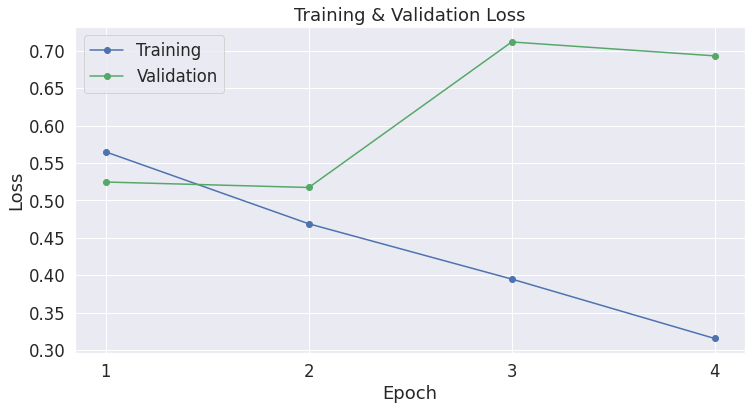

In [37]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [38]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.56,0.52,0.76,0:01:21,0:00:03
2,0.47,0.52,0.78,0:01:21,0:00:03
3,0.39,0.71,0.79,0:01:21,0:00:03
4,0.32,0.69,0.79,0:01:21,0:00:03


In [39]:
evaluation(y_val_offensive, y_pred_val_offensive)

Fine Grained Accuracy = 0.7894736842105263


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       278
           1       0.63      0.52      0.57       102

    accuracy                           0.79       380
   macro avg       0.73      0.70      0.72       380
weighted avg       0.78      0.79      0.78       380



In [40]:
result_df = pd.DataFrame(y_pred_val_offensive, index = val_data.index, columns=['offensive'])
result_df.index.name = 'Unique ID'
result_df.to_csv('y_pred_val_offensive.csv')

**Training for Offensive Class (Using Train +Val Data and Test Data)**

In [41]:
train_val_labels_offensive = y_train_val_offensive

In [42]:
input_ids, attention_masks = X_process(train_val_sentences)
train_val_dataloader = train_val_load(input_ids, attention_masks, train_val_labels_offensive)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_val_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [44]:
training_stats, y_pred_offensive = train_fn_test(train_val_dataloader, test_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    382.    Elapsed: 0:00:10.
  Batch    80  of    382.    Elapsed: 0:00:19.
  Batch   120  of    382.    Elapsed: 0:00:29.
  Batch   160  of    382.    Elapsed: 0:00:38.
  Batch   200  of    382.    Elapsed: 0:00:48.
  Batch   240  of    382.    Elapsed: 0:00:58.
  Batch   280  of    382.    Elapsed: 0:01:07.
  Batch   320  of    382.    Elapsed: 0:01:17.
  Batch   360  of    382.    Elapsed: 0:01:27.

  Average training loss: 0.39
  Training epcoh took: 0:01:32

Running Validation...
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.38509326056986853, 'Training Time': '0:01:32', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    382.    Elapsed: 0:00:10.
  Batch    80  of    382.    Elapsed: 0:00:19.
  Batch   120  of    382.    Elapsed: 0:00:29.
  Batch   160  of    382.    Elapsed: 0:00:38.
  Batch   200  of    382.    Elapsed: 0:00:48.
  Batch   240  of    382.    Elap

**Evaluation on Test Set**

In [46]:
df_stats  = stats(training_stats)

In [47]:
df_stats

,Training Loss,Training Time,Validation Time
epoch,,,
1,0.39,0:01:32,0:00:06
2,0.32,0:01:32,0:00:06
3,0.23,0:01:31,0:00:06
4,0.17,0:01:31,0:00:06


In [48]:
result_df = pd.DataFrame(y_pred_offensive, index = test_data.index, columns=['offensive'])
result_df.index.name = 'Unique ID'
result_df.to_csv('y_pred_test_offensive.csv')

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
model_save_name = 'offensive_test.tar'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)